In [1]:
import os
import re
import glob
import torch, torchvision
import sklearn
import random
import numpy as np
import polars as pl

import matplotlib.pyplot as plt

import PIL

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [8]:
DATA_DIR = "/Users/mayar.ali/Documents/phd/conferences/Oxford ML Summer School/Cases/carcinoma_classification/data/images/"
checkpoint = "/Users/mayar.ali/Documents/phd/conferences/Oxford ML Summer School/Cases/carcinoma_classification/checkpoint/"

In [4]:
from segment_anything import SamPredictor, sam_model_registry

In [9]:
sam = sam_model_registry["vit_h"](checkpoint=f"{checkpoint}/sam_vit_h_4b8939.pth")

In [10]:
import pandas as pd

In [12]:
labels = pd.read_csv(f"{DATA_DIR}/labels.csv")
train_y = labels["malignant"].values
train_y = torch.Tensor(train_y+1).to(torch.int64)

In [13]:
ids = labels["id"].values

In [14]:
import cv2

In [15]:
predictor = SamPredictor(sam)

In [16]:
for i, _id in enumerate(ids):
    image = cv2.imread(f"{DATA_DIR}/img_{_id}.png")
    predictor.set_image(image)
    
    img_embedding = predictor.get_image_embedding()
    
    if i == 0:
        train_x = img_embedding.reshape(
            (
                img_embedding.shape[0],
                img_embedding.shape[1]*img_embedding.shape[2]*img_embedding.shape[3]
            )
        )
    else:
        train_x = torch.cat((train_x, img_embedding.reshape(
            (
                img_embedding.shape[0],
                img_embedding.shape[1]*img_embedding.shape[2]*img_embedding.shape[3]
            )
        )), dim=0)

In [17]:
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.pyplot as plt

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 62 samples in 0.029s...
[t-SNE] Computed neighbors for 62 samples in 45.154s...
[t-SNE] Computed conditional probabilities for sample 62 / 62
[t-SNE] Mean sigma: 46.635826
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.161118
[t-SNE] KL divergence after 750 iterations: 0.025252


/var/folders/v4/bvrmrlts5qb7pdsxz_52lkf1cjgg2l/T/ipykernel_62416/2097249772.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


NameError: name 'indices' is not defined

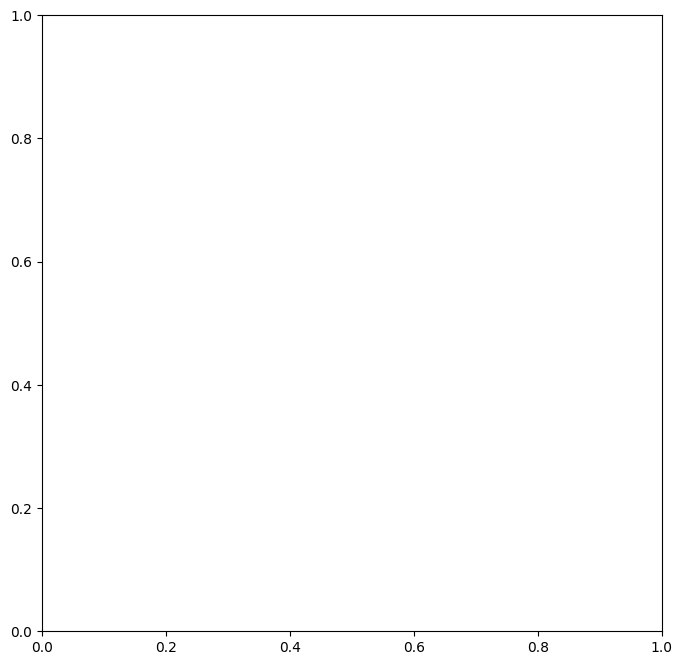

In [19]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(train_x)

/var/folders/v4/bvrmrlts5qb7pdsxz_52lkf1cjgg2l/T/ipykernel_62416/1886409073.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


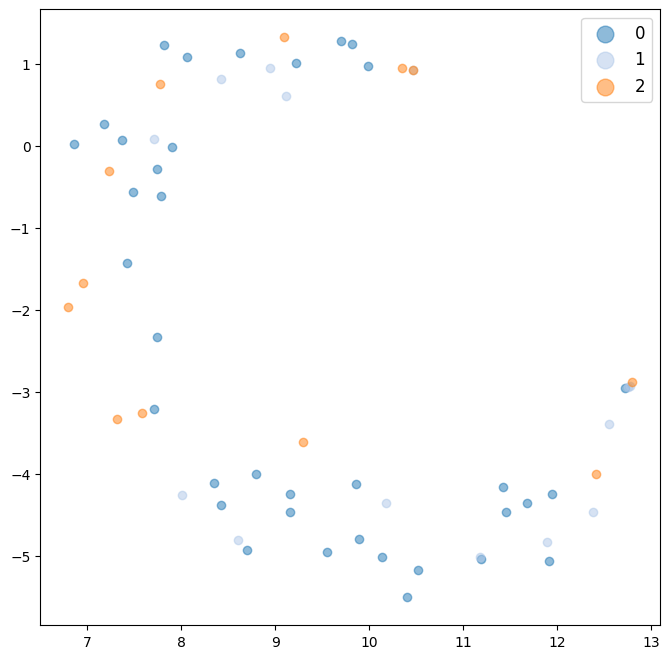

In [20]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_classes = 3
for lab in range(num_classes):
    indices = train_y == lab
    ax.scatter(
        tsne_proj[indices, 0], tsne_proj[indices, 1],
        c = np.array(cmap(lab)).reshape(1,4),
        label = lab,
        alpha=0.5,
    )
ax.legend(fontsize="large", markerscale=2)
plt.show()

In [21]:
classification_device = 'cpu'

# https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/GP_Regression_on_Classification_Labels.html
# we copy almost exactly

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y.to(classification_device), learn_additional_noise=True)
classification_model = DirichletGPModel(train_x.to(classification_device), likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [22]:
training_iter = 40

# Find optimal classification_model hyperparameters
classification_model = classification_model.to(classification_device)
classification_model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, classification_model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from classification_model
    output = classification_model(train_x.to(classification_device))
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            classification_model.covar_module.base_kernel.lengthscale.mean().item(),
            classification_model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/40 - Loss: 12.903   lengthscale: 0.693   noise: 0.693
Iter 6/40 - Loss: 11.401   lengthscale: 0.693   noise: 0.972
Iter 11/40 - Loss: 10.269   lengthscale: 0.693   noise: 1.298
Iter 16/40 - Loss: 9.455   lengthscale: 0.693   noise: 1.646
Iter 21/40 - Loss: 8.889   lengthscale: 0.693   noise: 1.987
Iter 26/40 - Loss: 8.502   lengthscale: 0.693   noise: 2.301
Iter 31/40 - Loss: 8.237   lengthscale: 0.693   noise: 2.575
Iter 36/40 - Loss: 8.054   lengthscale: 0.693   noise: 2.803


In [26]:
all_ids = []
for img in os.listdir(DATA_DIR):
    try:
        all_ids.append(img.split(".")[0].split("_")[1])
    except:
        continue

In [56]:
all_ids = [int(_id) for _id in all_ids]

In [62]:
test_ids = list(set(all_ids) - set(list(ids)))

In [30]:
for i, _id in enumerate(test_ids):
    image = cv2.imread(f"{DATA_DIR}/img_{_id}.png")
    predictor.set_image(image)
    
    img_embedding = predictor.get_image_embedding()
    
    if i == 0:
        test_x = img_embedding.reshape(
            (
                img_embedding.shape[0],
                img_embedding.shape[1]*img_embedding.shape[2]*img_embedding.shape[3]
            )
        )
    else:
        test_x = torch.cat((test_x, img_embedding.reshape(
            (
                img_embedding.shape[0],
                img_embedding.shape[1]*img_embedding.shape[2]*img_embedding.shape[3]
            )
        )), dim=0)

In [31]:
classification_model.eval()
likelihood.eval()

test_dist = classification_model(test_x.to(classification_device))
pred_means = test_dist.loc



In [32]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

In [35]:
torch.save(train_x, 'tensor_train_x.pt')

In [36]:
torch.save(test_x, 'tensor_train_x.pt')

In [38]:
index = []
test_labels = []
for i, id in enumerate(test_ids):
    index.append(id)
    test_labels.append(torch.argmax(probabilities[:, i]).cpu().detach().numpy() - 1)

In [42]:
test_submission = pd.DataFrame()
test_submission["id"] = list(test_ids)
test_submission["malignant"] = test_labels

In [81]:
test_submission["id"] = id_label
test_submission["malignant"] = malignant_label


In [82]:
test_submission

,id,malignant
0,310272,-1
1,105480,-1
2,731663,-1
3,789519,-1
4,367119,-1
...,...,...
119,93671,-1
120,646642,-1
121,959476,-1
122,28148,-1


In [83]:
write = True
if write:
    test_submission.to_csv('submission_sam.csv', index=False)